In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import functional as VF
from torchmetrics.classification import BinaryJaccardIndex
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
import pandas as pd
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import random
import data_pipeline
from skimage import morphology
from skimage.io import imread, imsave
imwrite = imsave

In [37]:
import unet
import r2u_att
import attunet

# model = unet.UNet(n_channels=1, n_classes=1, n_steps=4, with_pl=True)
# model_B = unet.UNet(n_channels=1, n_classes=1, n_steps=4, with_pl=True)
# model = baseline.Baseline()
model = r2u_att.R2U_Net(img_ch=1, output_ch=1, t=2)
model_B = attunet.AttU_Net(img_ch=1, output_ch=1)
model.load_state_dict(torch.load('./checkpoints/r2u/r2u_e50.pt', map_location=torch.device('cpu')))
model_B.load_state_dict(torch.load('./checkpoints/r2u/attunet_100e.pt', map_location=torch.device('cpu')))
# model_B.load_state_dict(torch.load('./checkpoints/r2u/attunet_100e.pt', map_location=torch.device('cpu')))
test_df = data_pipeline.build_test_dataframe(use_processed_images=False, limit_well_number=None)
train_df = data_pipeline.build_dataframe(use_processed_images=False, limit_well_number=None)

X_test, X_names, X_train, Y_train, outliers = data_pipeline.build_test_dataloaders(test_df, train_df, keep_negs=False)

test_dl = DataLoader(TensorDataset(X_test), batch_size=1)
train_dl = DataLoader(TensorDataset(X_train, Y_train), batch_size=1)


# Examining model output

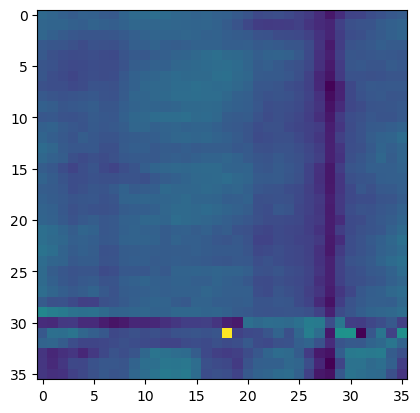

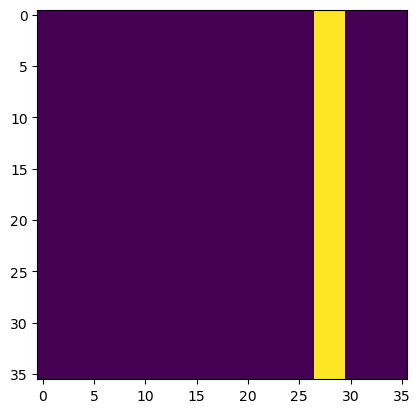

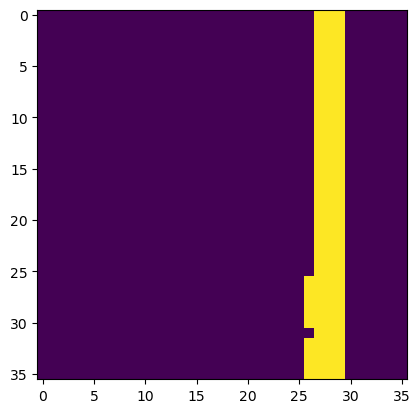

In [19]:
example = 1
img = X_train[example].reshape(-1, 1, 36,36)
label = Y_train[example].reshape(-1, 1, 36,36)

plt.imshow(img.view(36, 36))
plt.show()

model.eval()
# model_B.eval()
with torch.no_grad():
    out_1,_ = model(img)
    pred_1 = ((F.sigmoid(out_1) > .5)*1)
    # source = discriminator(features_1)
    # print(f"Pred source: ", torch.round(source))

plt.imshow(label.view(36, 36))
plt.show()

plt.imshow(pred_1.view(36, 36))
plt.show()

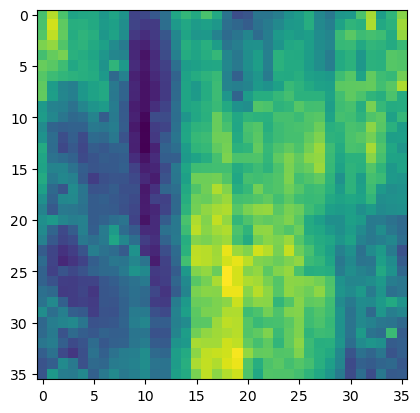

pred class_1:  tensor([[1.]])


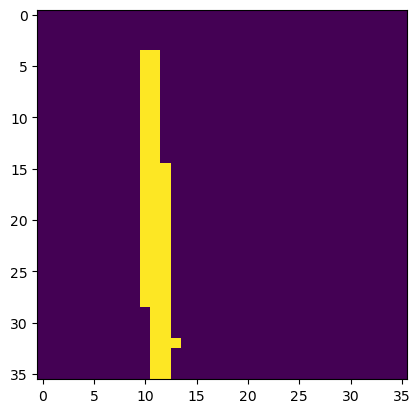

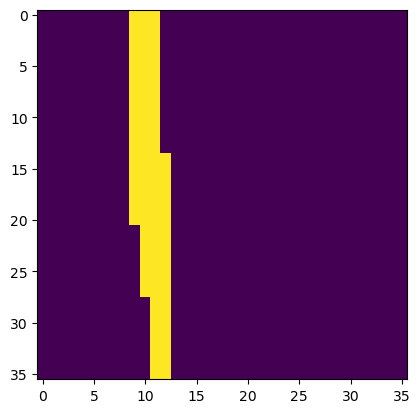

In [39]:
example = 9
img = X_test[example].reshape(-1, 1, 36,36)

plt.imshow(img.view(36, 36))
plt.show()

model.eval()
model_B.eval()
# discriminator.eval()
with torch.no_grad():
    out_1,class_1 = model(img)
    out_2,_, = model_B(img)
    pred_1 = ((F.sigmoid(out_1) > .5)*1)
    pred_2 = ((F.sigmoid(out_2) > .5)*1)
    
    # source = discriminator(features_1)
    # print(f"Pred source: ", torch.round(source))

print(f"pred class_1: ", torch.round(F.sigmoid(class_1)))
plt.imshow(pred_1.view(36, 36))
plt.show()

# print(f"pred class_2: ", torch.round(F.sigmoid(class_2)))
plt.imshow(pred_2.view(36, 36))
plt.show()

In [62]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = torch.sum(pred_mask)
    precision = torch.mean(intersect/(total_pixel_pred+1e-6))
    return precision

def recall_score_(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = torch.sum(groundtruth_mask)
    recall = torch.mean(intersect/(total_pixel_truth+1e-6))
    return recall

In [63]:
sigmoid_level = .5
total_precision = []
total_recall = []
with torch.no_grad():
  predictions = {}
  model.eval()
  for x, y in tqdm(train_dl):
    input = x
    mask = y.reshape(36, 36)
    out, _ = model(input)
    preds = ((F.sigmoid(out) > sigmoid_level)*1.).reshape(36, 36)
    total_precision.append(precision_score_(mask, preds))
    total_recall.append(recall_score_(mask, preds))
print(f"Average precision on train: {np.mean(total_precision)}")
print(f"Average recall on train:    {np.mean(total_recall)}")

  0%|          | 0/9330 [00:00<?, ?it/s]

100%|██████████| 9330/9330 [03:16<00:00, 47.39it/s]


Average precision on train: 0.7025871872901917
Average recall on train:    0.7327790856361389


In [64]:
sigmoid_level = .1
total_precision = []
total_recall = []
with torch.no_grad():
  predictions = {}
  model.eval()
  for x, y in tqdm(train_dl):
    input = x
    mask = y.reshape(36, 36)
    out, _ = model(input)
    preds = ((F.sigmoid(out) > sigmoid_level)*1.).reshape(36, 36)
    total_precision.append(precision_score_(mask, preds))
    total_recall.append(recall_score_(mask, preds))
print(f"Average precision on train: {np.mean(total_precision)}")
print(f"Average recall on train:    {np.mean(total_recall)}")

100%|██████████| 9330/9330 [03:09<00:00, 49.24it/s]


Average precision on train: 0.6592340469360352
Average recall on train:    0.7640684843063354


In [65]:
sigmoid_level = .3
total_precision = []
total_recall = []
with torch.no_grad():
  predictions = {}
  model.eval()
  for x, y in tqdm(train_dl):
    input = x
    mask = y.reshape(36, 36)
    out, _ = model(input)
    preds = ((F.sigmoid(out) > sigmoid_level)*1.).reshape(36, 36)
    total_precision.append(precision_score_(mask, preds))
    total_recall.append(recall_score_(mask, preds))
print(f"Average precision on train: {np.mean(total_precision)}")
print(f"Average recall on train:    {np.mean(total_recall)}")

100%|██████████| 9330/9330 [03:10<00:00, 49.04it/s]


Average precision on train: 0.689048171043396
Average recall on train:    0.7459034323692322


# Evaluating model

In [15]:
with torch.no_grad():
  predictions = {}
  model.eval()
  for index, x in tqdm(test_dl):
    input = x[0]
    out, _, = model(input)
    preds = (F.sigmoid(out) > .5)*1.
    if outliers[index]:
      preds = torch.zeros_like(out)
    name = X_names[index][0]
    predictions[name] = preds.flatten().tolist()

0it [00:00, ?it/s]

2538it [02:14, 18.81it/s]


In [16]:
preds_df = pd.DataFrame.from_dict(predictions, orient='index')

In [17]:
preds_df.to_csv('./outputs/KIRBY_predictions_30.csv')

# Pipe Prediction

In [10]:

def get_pipe_id_dataloaders(train_dataframe, valid_dataframe):
  data = torch.from_numpy(np.vstack(train_dataframe['data'].to_numpy()))
  data = torch.nan_to_num(data)
  labels = torch.from_numpy(np.vstack(train_dataframe['labels'].to_numpy()))

  valid_data = torch.from_numpy(np.vstack(valid_dataframe['data'].to_numpy()))
  valid_data = torch.nan_to_num(valid_data)
  valid_labels = torch.from_numpy(np.vstack(valid_dataframe['well_number'].to_numpy())).squeeze() - 1
  X_names = np.vstack(valid_dataframe['filename'].to_numpy())

  X_train, X_valid = data.float().reshape(-1, 1, 36, 36), valid_data.float().reshape(-1, 1, 36, 36)
  Y_train, Y_valid = labels, valid_labels

  return X_train, X_valid, Y_train, Y_valid, X_names

In [11]:
import pipe_identifier
import json

X_train, X_valid, Y_train, Y_valid, X_names = get_pipe_id_dataloaders(data_pipeline.build_dataframe(), data_pipeline.build_test_dataframe())
model = pipe_identifier.PipeIdentifier(num_classes=15)
model.load_state_dict(torch.load('./well_classifier_3.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [12]:
pipe_id_dataloader = DataLoader(TensorDataset(X_valid), batch_size=1)

In [13]:
predictions = {}
model.eval()
for index, x in tqdm(enumerate(pipe_id_dataloader)):
  out = model(x[0])
  preds = torch.argmax(F.softmax(out, dim=1))
  name = X_names[index][0]
  predictions[name] = preds.flatten().tolist()

2538it [00:18, 139.39it/s]


In [14]:
preds_df = pd.DataFrame.from_dict(predictions, orient='index')

In [15]:
preds_df.value_counts()

12    2334
9       97
10      79
2       21
5        4
6        2
4        1
Name: count, dtype: int64

In [16]:
predictions = {}
model.eval()
for index, x in tqdm(enumerate(X_train)):
  out = model(x.unsqueeze(dim=0))
  preds = torch.argmax(F.softmax(out, dim=1))
  name = Y_train[index][0]
  predictions[name] = preds.flatten().tolist()

0it [00:00, ?it/s]

9670it [01:11, 135.99it/s]


In [20]:
preds_df = pd.DataFrame.from_dict(predictions, orient='index')
preds_df[0] += 1

In [21]:
preds_df.value_counts()

13    5081
3     2197
11    1517
7      438
10     190
2      162
6       74
1        8
15       2
9        1
Name: count, dtype: int64

# Performance so far


## Unets

- Unet 5  - 0.38 validation IoU - Two Down Convs + All Images Scaled + Bulk Augments
- Unet 8  - 0.64 validation IoU - Two Down Convs + No Scaling + Random Augments
- Unet 9  - 0.63 validation IoU - Three down convs + No Scaling + Random Augments
- Unet 10 - 0.57 validation IoU - One down conv + No Scaling + Random Augments


However on the test set our results are much worse. But it appears that the scaling does not make much of a difference

When looking at the output we are just predicting 0.0 for everything, and that is how we wind up with an unchanged score

- Unet 11 - 0.59 train IoU - Two Down Convs + No Scaling + Random Augments + No Train Test Split
  - predicts 481 total 1.0... probably not it either
- Unet 12 - 0.58 train IoU - Two Down Convs + Robust Scaler on full Train Set + Random Augments + No Train Test Split
  - predicts 3091 1.0 values, maybe this is the next one to test?
- Unet 13 - 0.66 train IoU - Full Unet + Robust Scaler on full Train Set + Random Augments + No Train Test Split
  - predicts 41 1.0 values... not it...
- Unet 14 - After using KFolds to find the best Unet, we were able to beat the baseline score!
  - Important to note that there are outlier values in the testing set, deciding what to do with these examples will help our score


## Baselines

- We tested a baseline trained only on well 3 (baseline_4), and it succeeds in producing output that is not only one specific class. This demonstrates that on a single well, it is possible to implement the baseline. 
- We were able to reach the baseline score.

In [16]:
# fixing 14
df_14 = pd.read_csv('./outputs/KIRBY_predictions_14.csv')
df_14

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
0,well_5_patch_1864,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,well_5_patch_1419,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,well_5_patch_835,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,well_5_patch_770,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,well_5_patch_1846,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,well_5_patch_588,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2534,well_3_patch_325,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2535,well_5_patch_1065,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2536,well_5_patch_1763,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
cols = [str(i) for i in range(1296)]
df_14.replace('False', 0., inplace=True)
df_14.replace('True', 1., inplace=True)

In [23]:
df_14

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
0,well_5_patch_1864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,well_5_patch_1419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,well_5_patch_835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,well_5_patch_770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,well_5_patch_1846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,well_5_patch_588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2534,well_3_patch_325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2535,well_5_patch_1065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2536,well_5_patch_1763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_14.to_csv('./outputs/KIRBY_predictions_15.csv', index=False)

# Adv Training

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import unet
from train_unet import DEVICE, DiceBCELoss, PseduoLabelBCELoss
from torchmetrics.classification import BinaryJaccardIndex
import data_pipeline
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm

def diff_augment(image, label):
    axis = 2
    roll_distance = np.random.randint(0, 36, size=(image.shape[0], 1))
    image = torch.roll(image, roll_distance, dims=axis)
    label = torch.roll(label, roll_distance, dims=axis)

    flip = np.random.randint(2) % 2 == 0
    if (flip):
        image = torch.flip(image, dims=3)
        label = torch.flip(image, dims=3)

    return image, label

def build_tensors(test_dataframe, train_dataframe):
    test_data = torch.from_numpy(np.vstack(test_dataframe['data'].to_numpy()))
    test_data = torch.nan_to_num(test_data)
    
    outliers = ((test_data.min(dim=1, keepdim=True).values < -10) == True).flatten()
    test_df = test_dataframe.drop(test_dataframe.loc[outliers.tolist()].index)
    
    test_data = torch.from_numpy(np.vstack(test_df['data'].to_numpy()))
    test_data = torch.nan_to_num(test_data)

    X_names = np.vstack(test_df['filename'].to_numpy())

    train_data = torch.from_numpy(np.vstack(train_dataframe['data'].to_numpy()))
    train_data = torch.nan_to_num(train_data)
    Y_train = torch.from_numpy(np.vstack(train_dataframe['labels'].to_numpy()))

    train_data, test_data = train_data.reshape(-1, 36*36), test_data.reshape(-1, 36*36)
    scaler = RobustScaler().fit(train_data)
    train_data = torch.tensor(scaler.transform(train_data)).float().reshape(-1, 1, 36, 36)
    test_data = torch.tensor(scaler.transform(test_data)).float().reshape(-1, 1, 36, 36)

    X_test = test_data.float().reshape(-1, 1, 36, 36)
    X_train = train_data.float().reshape(-1, 1, 36, 36)
    return X_test, X_names, X_train, Y_train


test_df = data_pipeline.build_test_dataframe(use_processed_images=False, limit_well_number=None)
train_df = data_pipeline.build_dataframe(use_processed_images=False, limit_well_number=None)

X_test, X_names, X_train, Y_train = build_tensors(test_df, train_df)

target_dataset = data_pipeline.WellsDataset(X_test, torch.zeros(len(X_test), 1), transform=None, wells=None)
target_dl = DataLoader(target_dataset, batch_size=128)

source_dataset = data_pipeline.WellsDataset(X_train, Y_train.float().reshape(-1, 1, 36, 36), transform=None, wells=None)
source_dl = DataLoader(source_dataset, batch_size=128)

adversarial_loss = torch.nn.BCELoss(reduction='mean')

# Define your UNet, discriminator, and optimizer
generator = unet.UNet(n_channels=1, n_classes=1, n_steps=4, with_pl=True)
generator.load_state_dict(torch.load('./checkpoints/unet/unet_16.pt', map_location=DEVICE))
generator = generator.to(DEVICE)

discriminator = unet.Unet_Discriminator(n_classes=1).to(DEVICE)

adversarial_weight_source = 1.0 
adversarial_weight_target = 1.0 
lmbda = 1.0

optimizer_generator = optim.Adam(generator.parameters())
optimizer_discriminator = optim.Adam(discriminator.parameters())

metric = BinaryJaccardIndex().to(DEVICE)
dice_criterion = DiceBCELoss().to(DEVICE)
pseudo_labeling_criterion = PseduoLabelBCELoss()

num_epochs = 50

def train_dassl_uda():
        # Training loop
    for epoch in range(num_epochs):
        source_dl = DataLoader(source_dataset, batch_size=128, shuffle=True)
        source_iterator = iter(source_dl)

        generator_losses = []

        for (target_data, target_labels) in tqdm(target_dl):
            # Train the discriminator
            source_data, source_labels = next(source_iterator)
            
            optimizer_generator.zero_grad()

            if len(target_data) != len(source_data):
                # end of batch
                source_data = source_data[0:len(target_data)]
                source_labels = source_labels[0:len(target_data)]
        
            source_images = source_data.to(DEVICE)
            source_labels = source_labels.to(DEVICE)

            target_images = target_data.to(DEVICE)
            target_labels = target_labels.to(DEVICE)

            source_preds, source_class_pred, _ = generator(source_images)
            source_dice_loss = dice_criterion(source_preds, source_labels, weights=None)
            source_class_loss = pseudo_labeling_criterion(source_class_pred, source_labels, weights=None)
            
            target_preds, target_class_preds, _ = generator(target_images)
            target_output = F.sigmoid(target_preds, 1)
            target_loss = (-target_output * torch.log(target_output + 1e-5)).sum(1).mean()
            target_class_output = F.sigmoid(target_class_preds, _)
            target_class_loss = (-target_class_output * torch.log(target_class_output + 1e-5)).sum(1).mean()

            loss = source_dice_loss + source_class_loss + (target_loss + target_class_loss) * lmbda
            loss.backward()

            generator_losses.append(loss.item())
            optimizer_generator.step()

        # test Validation of model on rest of training set
        with torch.no_grad():
            generator.eval()
            train_iou = []
            for (input, labels) in tqdm(source_iterator):
                input = input.to(DEVICE)
                labels = labels.to(DEVICE)
                preds,pseudo_label,_ = generator(input)

                dice_loss = dice_criterion(preds, labels, weights=None)
                class_loss = pseudo_labeling_criterion(pseudo_label, labels, weights=None)
                loss = dice_loss + class_loss
                train_iou.append(metric(preds, labels).item())


        print("-"*100)
        print(f"epoch: {epoch}")
        print(f"Losses:")
        print(f"Generator loss:      {np.mean(generator_losses)}")
        print(f"Accs:")
        print(f"Generator train IoU: {np.mean(train_iou)}")
    
    torch.save(generator.state_dict(), './unet_16_uda_emin_1.pt')

def train_adversarial_uda():
    # Training loop
    for epoch in range(num_epochs):
        source_dl = DataLoader(source_dataset, batch_size=128, shuffle=True)
        source_iterator = iter(source_dl)

        discriminator_losses = []
        generator_losses = []

        discriminator_source_accs = []
        discriminator_target_accs = []
        generator_accs = []

        for (target_data, target_labels) in tqdm(target_dl):
            # Train the discriminator
            source_data, _ = next(source_iterator)
            source_labels = torch.ones(len(target_data), 1)

            optimizer_discriminator.zero_grad()
            generator.eval()

            if len(target_data) != len(source_data):
                # end of batch
                source_data = source_data[0:len(target_data)]
                source_labels = source_labels[0:len(target_data)]
        
            source_images = source_data.to(DEVICE)
            source_labels = source_labels.to(DEVICE)

            target_images = target_data.to(DEVICE)
            target_labels = target_labels.to(DEVICE)

            _, _, source_features = generator(source_images)
            source_features = source_features.detach()
            _, _, target_features = generator(target_images)
            target_features = target_features.detach()

            discrim_on_source = discriminator(source_features)
            discrim_on_target = discriminator(target_features)

            discriminator_loss_source = adversarial_loss(discrim_on_source, source_labels) * adversarial_weight_source
            discriminator_loss_target = adversarial_loss(discrim_on_target, target_labels) * adversarial_weight_target
            discriminator_loss = discriminator_loss_source + discriminator_loss_target
            discriminator_losses.append(discriminator_loss.item())
            discriminator_loss.backward()

            discrim_source_accuracy = torch.sum((torch.round(discrim_on_source) == source_labels)) / len(source_labels)
            discrim_target_accuracy = torch.sum((torch.round(discrim_on_target) == target_labels)) / len(target_labels)

            discriminator_source_accs.append(discrim_source_accuracy.cpu().detach())
            discriminator_target_accs.append(discrim_target_accuracy.cpu().detach())

            optimizer_discriminator.step()

            # Train the generator
            generator.train()
            optimizer_generator.zero_grad()

            _, _, source_features = generator(source_images)
            _, _, target_features = generator(target_images)

            discrim_from_gen_source = discriminator(source_features)
            discrim_from_gen_target = discriminator(target_features)

            generator_loss_source = adversarial_loss(discrim_from_gen_source, target_labels) * adversarial_weight_source
            generator_loss_target = adversarial_loss(discrim_from_gen_target, source_labels) * adversarial_weight_target
            generator_loss = generator_loss_source + generator_loss_target
            generator_losses.append(generator_loss.item())
            generator_loss.backward()

            generator_accuracy = torch.sum((torch.round(discrim_from_gen_source) == target_labels)) + torch.sum((torch.round(discrim_from_gen_target) == source_labels))
            generator_accuracy = generator_accuracy.item()
            generator_accuracy /= (len(target_labels) + len(source_labels))
            generator_accs.append(generator_accuracy)

            optimizer_generator.step()

        # test Validation of model on rest of training set
        train_iou = []
        for (input, labels) in tqdm(source_iterator):
            input = input.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer_generator.zero_grad()
            preds,pseudo_label,_ = generator(input)

            dice_loss = dice_criterion(preds, labels, weights=None)
            class_loss = pseudo_labeling_criterion(pseudo_label, labels, weights=None)
            loss = dice_loss + class_loss
            loss.backward()
            train_iou.append(metric(preds, labels).item())
            optimizer_generator.step()


        print("-"*100)
        print(f"epoch: {epoch}")
        print(f"Losses:")
        print(f"Discriminator loss: {np.mean(discriminator_losses)}")
        print(f"Generator loss: {np.mean(generator_losses)}")
        print(f"Accs:")
        print(f"Discrim on Source:          {np.mean(discriminator_source_accs)}")
        print(f"Discrim on Target:          {np.mean(discriminator_target_accs)}")
        print(f"Generator tricking discrim: {np.mean(generator_accs)}")
        print(f"Generator train IoU:        {np.mean(train_iou)}")


    torch.save(generator.state_dict(), './unet_16_uda_2.pt')
    torch.save(discriminator.state_dict(), './discriminator_3.pt')


In [65]:
# Training loop
for epoch in range(num_epochs):
    source_dl = DataLoader(source_dataset, batch_size=128, shuffle=True)
    source_iterator = iter(source_dl)

    generator_losses = []

    for (target_data, target_labels) in tqdm(target_dl):
        # Train the discriminator
        source_data, source_labels = next(source_iterator)
        
        optimizer_generator.zero_grad()

        if len(target_data) != len(source_data):
            # end of batch
            source_data = source_data[0:len(target_data)]
            source_labels = source_labels[0:len(target_data)]
    
        source_images = source_data.to(DEVICE)
        source_labels = source_labels.to(DEVICE)

        target_images = target_data.to(DEVICE)
        target_labels = target_labels.to(DEVICE)

        source_preds, source_class_pred, _ = generator(source_images)
        source_dice_loss = dice_criterion(source_preds, source_labels, weights=None)
        source_class_loss = pseudo_labeling_criterion(source_class_pred, source_labels, weights=None)
        
        target_preds, target_class_preds, _ = generator(target_images)
        target_output = F.sigmoid(target_preds)
        target_loss = (-target_output * torch.log(target_output + 1e-5)).sum(1).mean()
        target_class_output = F.sigmoid(target_class_preds)
        target_class_loss = (-target_class_output * torch.log(target_class_output + 1e-5)).sum(1).mean()

        loss = source_dice_loss + source_class_loss + (target_loss + target_class_loss) * lmbda
        loss.backward()

        generator_losses.append(loss.item())
        optimizer_generator.step()

    # test Validation of model on rest of training set
    with torch.no_grad():
        generator.eval()
        train_iou = []
        for (input, labels) in tqdm(source_iterator):
            input = input.to(DEVICE)
            labels = labels.to(DEVICE)
            preds,pseudo_label,_ = generator(input)

            dice_loss = dice_criterion(preds, labels, weights=None)
            class_loss = pseudo_labeling_criterion(pseudo_label, labels, weights=None)
            loss = dice_loss + class_loss
            train_iou.append(metric(preds, labels).item())


    print("-"*100)
    print(f"epoch: {epoch}")
    print(f"Losses:")
    print(f"Generator loss:      {np.mean(generator_losses)}")
    print(f"Accs:")
    print(f"Generator train IoU: {np.mean(train_iou)}")

torch.save(generator.state_dict(), './unet_16_uda_emin_1.pt')


  0%|          | 0/73 [00:00<?, ?it/s]/Users/ellington/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:890: UserWarning: MPS: _unique2 op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:323.)
  output, inverse_indices, counts = torch._unique2(
 74%|███████▍  | 54/73 [00:14<00:05,  3.72it/s]


----------------------------------------------------------------------------------------------------
epoch: 0
Losses:
Generator loss:      1234.3848234477796
Accs:
Generator train IoU: 0.7380519409974416


  0%|          | 0/19 [00:03<?, ?it/s]


KeyboardInterrupt: 